## Recommender Systems

[A recommender system](https://en.wikipedia.org/wiki/Recommender_system) is a subclass of information filtering system that provide suggestions for items that are most pertinent to a particular user. It works as an information filter to solve the information overload problem. 
* Personalized - tailored to individual users, based on a user's previous performance

* Non personalized - most popular, recent upload, based on aggregate activities of many other users 

__Basic question: what items will a user like ?__

Recommender systems aim to predict the “rating” or “preference” a user would give to an item. These ratings are used to determine what a user might like and make informed suggestions.

__User Preferences__:
* explicit data - rating, review, vote

* implicit data - click, purchase, follow

__Recommendation Approaches:__
  * Content-based filtering - relies on similarities between items themselves (uses item features to recommend other items similar to what the user likes)
                              
  * Collaborative filtering - relies on the assumption that similar users like similar items (recommend an item to the user based on the preference of other similar users) 

<img src="./Images/utility-matrix.png" 
     align="left" 
     width="800" />

The content-based approach doesn't require data on other users, but it's difficult to find appropriate features. The most significant benefit of collaborative filtering is its versatility, as it can be applied to any type of item without the need for feature selection. This explains the huge popularity of collaborative filtering because it is sort of obviating the feature selection for complex things such as images and movies.

A collaborative filtering recommender system has two types of entities - users and items. A important step in making recommendations is to build a utility matrix of ratings (or preferences).

__Utility Matrix:__
 * A matrix which consists of the rating (or preference) for each user-item pair
 * Sparsity arises when most items dosen't have ratings or the most active users have rated only a marginal number of available items

__The goal of a recommendation system is to predict the blanks in the utility matrix.__

Matrix factorization is an extensively used technique to estimate values of the blanks in collaborative filtering recommendation systems. Its objective is to factorize a user-item matrix into two latent factor matrices, the user-factor matrix and the item-factor matrix. This allows us to predict new items that users might be interested in by taking the inner product of these two factor matrices. Matrix factorization reduces the dimensionality of the utility matrix, which compresses data and remove redundant and noisy features.

<img src="./Images/matrix-factorization.png" 
     align="left" 
     width="800" />

__Methods for Implementing Matrix Factorization:__
* Principal component analysis (PCA, implemented by scikit-learn in Python)
* Singular value decomposition (SVD, implemented by scikit-surprise in Python)

## Autoencoder for Recommendations

Autoencoder is a kind of neural network for unsupervised learning tasks, capable of compressing data and reducing its dimensionality.

A basic autoencoder consists of three layers: input layer, hidden layer and output layer. The input layer and the hidden layer construct an encoder. The hidden layer and the output layer construct a decoder. The encoder encodes the high-dimensional input data into a low dimensional hidden representation. The decoder maps hidden representation back to a reconstruction of input data. This reconstruction allows to predict users’ preference for unseen items. 

In autoencoder-based recommender systems, autoencoder would help the system better understand users and items by learning the non-linear user-item relationship efficiently and encoding complex abstractions into data representations. This is because nonlinear activation functions are used during encoding and decoding, and the number of neurons in the hidden layer is reduced.

<img src="./Images/autoencoder.png" 
     align="left" 
     width="500" />

## An Autoecoder-based Movie Recommendation System

In [12]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## (a) Load dataset

In [3]:
# load data for moviee 100k (all users)
sel_cols = ["user_id", "movie_id", "rating", "unix_timestamp"]
rating_all = pd.read_csv("ml-100k/u.data", sep="\t", names=sel_cols, encoding="latin-1")
# ‘u1.base’ for training and validation
rating_train = pd.read_csv("ml-100k/u1.base", sep="\t", names=sel_cols, encoding="latin-1")
# ‘u1.test’ for testing
rating_test = pd.read_csv("ml-100k/u1.test", sep="\t", names=sel_cols, encoding="latin-1")
print(rating_all.shape)
print(rating_train.shape)
print(rating_test.shape)

(100000, 4)
(80000, 4)
(20000, 4)


In [10]:
# load items file
item_cols = ["movie_id", "movie_title", "release_date", "video_release_data", "IMDB_URL", 
        "unknown", "action", "adventure", "animation", "children's", "comedy", 
        "crime", "documentary", "drama", "fantasy", "film-noir", "horror", "musical", 
        "mystery", "romance", "sci-fi", "thriller", "war", "western"]
items = pd.read_csv("ml-100k/u.item", sep="|", names=item_cols, encoding="latin-1")

## (b) Autoencoder model

In [8]:
class UserEncoder(torch.nn.Module):
    def __init__(self, input_dim):
        super(UserEncoder, self).__init__()
        # encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512), 
            torch.nn.Linear(512, 256), 
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 32)
        )
        # decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 512),
            torch.nn.Linear(512, input_dim), 
            torch.nn.Sigmoid()
        )
        return 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## (c) Model training and testing 

In [ ]:
def user_data(rating, items):
    users_num = rating["user_id"].unique().shape[0]
    movies_num = items.shape[0]
    users = sorted(rating["user_id"].unique())
    user_data = np.zeros((users_num, movies_num)) # 0：a user hasn't watched a movie
    for i, user in enumerate(users):
        movies_watched = rating.loc[rating["user_id"]==user]["movie_id"].unique()-1
        user_data[i, movies_watched] = 1  # 1：a user has watched the movie
    return torch.Tensor(user_data)

In [18]:

data = user_data(rating_train, items)
sample_size = int(len(data)*0.8)
train_data = data[:sample_size].to(device)
val_data = data[sample_size:].to(device)
print("Training data size is {}".format(train_data.shape))
print("Validation data size is {}".format(val_data.shape))

Training data size is torch.Size([754, 1682])
Validation data size is torch.Size([189, 1682])


In [26]:
model = UserEncoder(train_data.shape[1]).to(device)
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_loss = []

EPOCHS = 150
for epoch in range(EPOCHS):
    train_data = train_data[torch.randperm(train_data.shape[0])]
    
    optimizer.zero_grad()
    train_predicted = model(train_data)
    loss = loss_function(train_predicted, train_data)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    
    model.eval()
    val_predicted = model(val_data)
    loss = loss_function(val_predicted, val_data)
    val_loss.append(loss.item())
    model.train()
    
_ = model.eval()

The figure of training/validation loss vs epoch


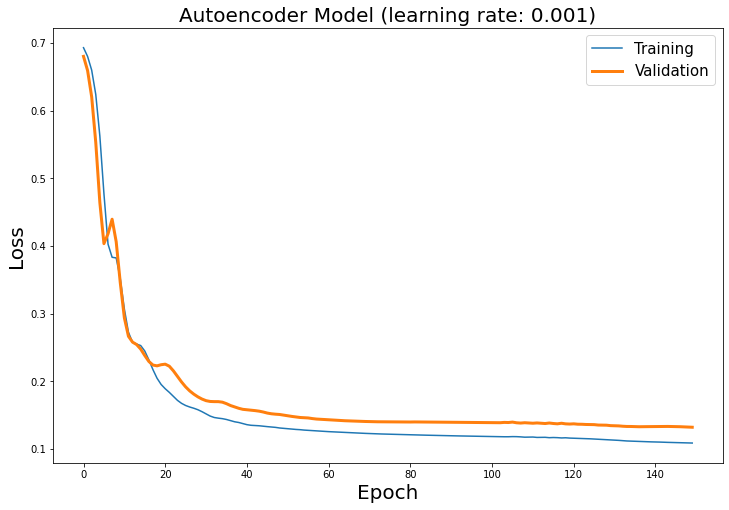

In [27]:
figure = plt.figure(figsize = [12, 8])
plt.plot(np.arange(len(train_loss[:])), train_loss[:], label='Training')
plt.plot(np.arange(len(val_loss[:])), val_loss[:], label='Validation', linewidth=3)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.title("Autoencoder Model (learning rate: 0.001)", fontsize=20)
plt.legend(fontsize=15)
plt.savefig('./hm3_pro2_autoencoder_loss.png')
plt.show() 

Evaluate the validation and test performance of the model.

In [31]:
test_data = user_data(rating_test, items).to(device)
test_predicted = model(test_data)
test_loss = loss_function(test_predicted, test_data).item()
print("The valiation loss is {:.6}".format(val_loss[149]))
print("The test loss is {:.6}".format(test_loss))

The valiation loss is 0.131984
The test loss is 0.0853348


Precision and recall for all users

In [ ]:
data_all = user_data(rating_all, items)
precision = []
recall = []

for user in range(data_all.shape[0]):
    user_targets = data_all[user].to(device)
    user_predictions = torch.round(model(user_targets))
    user_predictions = user_predictions.cpu().detach().numpy()
    user_targets = user_targets.cpu().detach().numpy()
    precision.append(precision_score(user_targets, user_predictions, zero_division=1))
    recall.append(recall_score(user_targets, user_predictions))

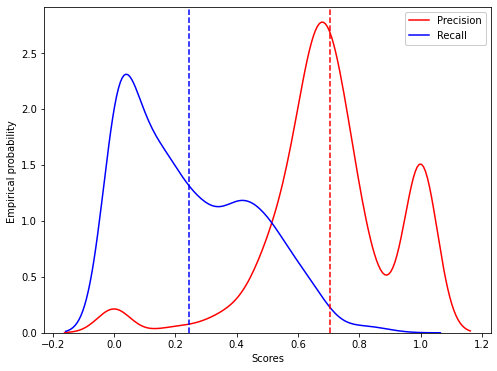

This figure shows the distribution of empirical probability for both precision and recall (dashed line refers to the average score).
The precision average score is 0.7040.
The recall average score is 0.2442.


In [50]:
figure = plt.figure(figsize = [8, 6])
ax = sns.kdeplot(precision, c='r')
ax = sns.kdeplot(recall, ax=ax, c='b')
plt.legend(["Precision", "Recall"], framealpha=1)
plt.axvline(x=np.mean(precision), c='r', ls="--")
plt.axvline(x=np.mean(recall), c='b', ls="--")
plt.ylabel("Empirical probability ")
plt.xlabel("Scores")
plt.show()

print("This figure shows the distribution of empirical probability for both precision and recall (dashed line refers to the average score).")
print("The precision average score is {:.4f}.".format(np.mean(precision)))
print("The recall average score is {:.4f}.".format(np.mean(recall)))

## (d) Recommend the top-10 best NEW movies 

In [47]:
movies_recom = {"User_ID": [], "Rating": [], "Movie_ID": [], }

for user in range(data_all.shape[0]):
    user_targets = data_all[user].to(device)

    user_predictions = model(user_targets).cpu().detach().numpy()
    user_targets = user_targets.cpu().detach().numpy()
    unwatched = np.multiply(user_targets==0, user_predictions) 
    recommended = np.argsort(unwatched)[::-1][:10] 
    user_rating = user_predictions[recommended]

    for r_s, m_id in zip(user_rating, recommended):
        movies_recom["User_ID"].append(user+1) 
        movies_recom["Rating"].append(r_s)
        movies_recom["Movie_ID"].append(m_id+1) 
        
movies_recom = pd.DataFrame(movies_recom)
movies_recom.to_csv("pred_autoencoder.txt", index=False)

print("The top-10 best NEW movies recommended to the first user:")
movies_recom.head(10)

The top-10 best NEW movies recommended by the first user:


,User_ID,Rating,Movie_ID
0,1,0.829406,423
1,1,0.828816,405
2,1,0.772716,385
3,1,0.748772,568
4,1,0.743764,546
5,1,0.724792,318
6,1,0.706313,367
7,1,0.695343,655
8,1,0.681420,288
9,1,0.666936,393
